In [1]:
import os
import sys
import bz2
import mpld3
import pandas as pd
import _pickle as cPickle
import svgutils.transform as sg
import matplotlib.pyplot as plt

from jazzy import core
from rdkit import Chem
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import PandasTools
from sklearn.metrics import mean_absolute_error, r2_score
from mpld3 import plugins
mpld3.enable_notebook()

In [2]:
# Import config
opt_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'optimisation'))
sys.path.insert(0, opt_path)
import config

# Open the compressed data
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', config.DATA_PATH))
optuna_path = os.path.join(data_path, config.OPTUNA_DIRNAME)
data_filepath = os.path.join(optuna_path, config.PRECALCULATED_DATA_FILENAME)
input_data = bz2.BZ2File(data_filepath, 'rb')
input_data = cPickle.load(input_data)

# Open the study
study_filepath = os.path.join(optuna_path, config.OPTUNA_DELTAG_STUDY_FILENAME)
study = bz2.BZ2File(study_filepath, 'rb')
study = cPickle.load(study)
best_params = study.best_trial.params
best_params

/home/kdxr003/.cache/pypoetry/virtualenvs/jazzy-ZuwbZvu4-py3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'gd': -0.9076664181509553,
 'ga': -16.13143317348325,
 'g0': 1.8842791231644282,
 'gs': 0.046698073586512054,
 'gr': -3.6429426011852524,
 'gpi1': -1.6022604035599135,
 'gpi2': -1.1740853831959548,
 'gi': 4.999560447432514,
 'F': 0.5143359987215719,
 'expd': 0.5041243951898653,
 'expa': 0.3436880638589098}

In [3]:
# Select parameters
gd = best_params['gd']              # gd=-139.0
ga = best_params['ga']              # ga=-32.0
g0 = best_params['g0']              # g0=5.53
gs = best_params['gs']              # gs=0.031
gr = best_params['gr']              # gr=-4.39
gpi1 = best_params['gpi1']          # gpi1=-1.82
gpi2 = best_params['gpi2']          # gpi2=-1.29   
gi = best_params['gi']              # gi=37.2
f = best_params['F']                # f=0.325
expd = best_params['expd']          # expd=0.68
expa = best_params['expa']          # expa=0.51

In [4]:
def moltosvg(mol, molSize=(100,100), kekulize=True, label=None):
    """Produces the rendering of an input RDKit molecule.
    """
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    s = svg.replace('svg:','')
    if label is not None:
        fig = sg.fromstring(s)
        label = sg.TextElement(80, 80, label, size=12, 
                        font='sans-serif', anchor='middle', color='#000000')
        fig.append(label)
        s = fig.to_str().decode("utf-8") 
    return s

In [5]:
def calculate_deltag(rdkit_mol, atomic_map, atoms_and_nbrs):
    """Calculate individual terms and return their sum
    """
    dgp = round(core.calculate_delta_polar(atomic_map, 
                                           atoms_and_nbrs, 
                                           gd=gd, 
                                           ga=ga,
                                           expd=expd,
                                           expa=expa), 
                                           4)

    dga = round(core.calculate_delta_apolar(rdkit_mol, 
                                            atomic_map,
                                            g0=g0,
                                            gs=gs,
                                            gr=gr,
                                            gpi1=gpi1,
                                            gpi2=gpi2),
                                            4)

    dgi = round(core.calculate_delta_interaction(rdkit_mol, 
                                                 atomic_map,
                                                 atoms_and_nbrs,
                                                 gi=gi,
                                                 expa=expa, 
                                                 f=f),
                                                 4)
    calc_deltag = dgp + dga + dgi
    return(calc_deltag)

In [6]:
names = []
flat_mols = []
y_exp = []
y_calc = []
y_recalc = []
y_recalc_no_min = []
y_mab = []
svgs = []

for idx in input_data:
    mol = input_data[idx]
    rdkit_mol= mol["rdkit_mol"]
    kallisto_mol = mol["kallisto_mol"]
    atoms_and_nbrs = mol["atoms_and_nbrs"]
    charges = mol["charges"]
    names.append(mol["name"])
    flat_mol = Chem.MolFromSmiles(mol["smiles"])
    flat_mols.append(flat_mol)
    svgs.append(moltosvg(flat_mol, label=str(idx)))
    y_exp.append(mol["exp_deltag"])
    y_mab.append(mol["mab_deltag"])

    # Run calculation from precalculated objects
    atomic_map = core.calculate_polar_strength_map(rdkit_mol, kallisto_mol, atoms_and_nbrs, charges)
    y_calc.append(calculate_deltag(rdkit_mol, atomic_map, atoms_and_nbrs))

    # Recalculate the whole shebang from SMILES to verify consistency across multiple calculations
    rdkit_mol = core.rdkit_molecule_from_smiles(mol["smiles"], minimisation_method="MMFF94")
    kallisto_mol = core.kallisto_molecule_from_rdkit_molecule(rdkit_mol)
    atoms_and_nbrs = core.get_covalent_atom_idxs(rdkit_mol)
    charges = core.get_charges_from_kallisto_molecule(kallisto_mol, charge=0)
    atomic_map = core.calculate_polar_strength_map(rdkit_mol, kallisto_mol, atoms_and_nbrs, charges)
    y_recalc.append(calculate_deltag(rdkit_mol, atomic_map, atoms_and_nbrs))

    # Recalculate without minimisation to see whether it still correlates or not
    rdkit_mol = core.rdkit_molecule_from_smiles(mol["smiles"], minimisation_method=None)
    kallisto_mol = core.kallisto_molecule_from_rdkit_molecule(rdkit_mol)
    atoms_and_nbrs = core.get_covalent_atom_idxs(rdkit_mol)
    charges = core.get_charges_from_kallisto_molecule(kallisto_mol, charge=0)
    atomic_map = core.calculate_polar_strength_map(rdkit_mol, kallisto_mol, atoms_and_nbrs, charges)
    y_recalc_no_min.append(calculate_deltag(rdkit_mol, atomic_map, atoms_and_nbrs))

In [7]:
print("Jazzy precalculated predictions vs. experimental data:", r2_score(y_exp, y_calc), mean_absolute_error(y_exp, y_calc))
print("Gerber's predictions vs. experimental data:", r2_score(y_exp, y_mab), mean_absolute_error(y_exp, y_mab))
print("Jazzy precalculated predictions vs. Jazzy recalculations with minimisation:", r2_score(y_calc, y_recalc), mean_absolute_error(y_calc, y_recalc))
print("Jazzy precalculated predictions vs. Jazzy recalculations without minimisation:", r2_score(y_calc, y_recalc_no_min), mean_absolute_error(y_calc, y_recalc_no_min))

Jazzy precalculated predictions vs. experimental data: 0.8314497121104009 3.817880136986301
Gerber's predictions vs. experimental data: 0.8985281494045481 2.469657534246575
Jazzy precalculated predictions vs. Jazzy recalculations with minimisation: 0.9989389439216778 0.1048976027397261
Jazzy precalculated predictions vs. Jazzy recalculations without minimisation: 0.9980575693946718 0.27657054794520575


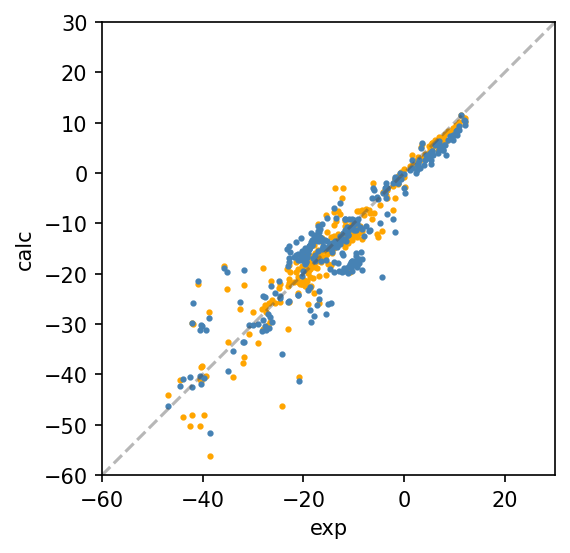

In [8]:
x = y_exp
y = y_calc
z = y_mab

"""Jazzy precalculated predictions vs. experimental data + Gerber's predictions vs. experimental data"""
fig, ax = plt.subplots(dpi=150)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3", alpha=0.4)
ax.scatter(x, z, s=4, color='orange')
points = ax.scatter(x, y, s=4, color='steelblue')
ax.set_aspect('equal', adjustable='box')
tooltip = plugins.PointHTMLTooltip(points, svgs)
plugins.connect(fig, tooltip)
plt.xlim(-60,30)
plt.ylim(-60,30)
plt.xlabel("exp")
plt.ylabel("calc")
plt.show()

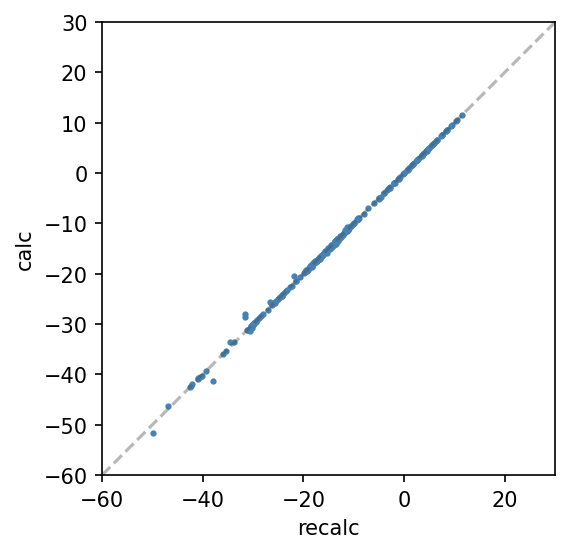

In [9]:
x = y_recalc
y = y_calc

"""Jazzy precalculated predictions vs. Jazzy recalculations with minimisation"""
fig, ax = plt.subplots(dpi=150)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3", alpha=0.4)
points = ax.scatter(x, y, s=4, color='steelblue')
ax.set_aspect('equal', adjustable='box')
tooltip = plugins.PointHTMLTooltip(points, svgs)
plugins.connect(fig, tooltip)
plt.xlim(-60,30)
plt.ylim(-60,30)
plt.xlabel("recalc")
plt.ylabel("calc")
plt.show()

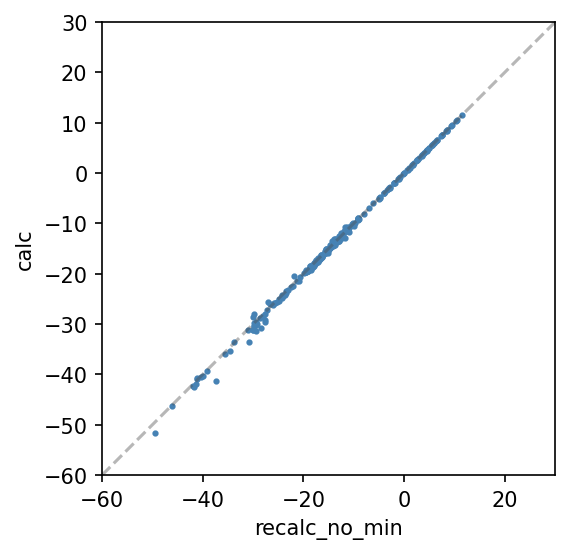

In [10]:
x = y_recalc_no_min
y = y_calc

"""Jazzy precalculated prediction vs. Jazzy recalculations without minimisation"""
fig, ax = plt.subplots(dpi=150)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3", alpha=0.4)
points = ax.scatter(x, y, s=4, color='steelblue')
ax.set_aspect('equal', adjustable='box')
tooltip = plugins.PointHTMLTooltip(points, svgs)
plugins.connect(fig, tooltip)
plt.xlim(-60,30)
plt.ylim(-60,30)
plt.xlabel("recalc_no_min")
plt.ylabel("calc")
plt.show()

In [11]:
abs_err_calc_exp = [abs(y_calc[x]) - abs(y_exp[x]) for x in range(len(y_calc))]
abs_err_mab_exp = [abs(y_mab[x]) - abs(y_exp[x]) for x in range(len(y_mab))]

"""Detailed performance spreadsheet"""
PandasTools.RenderImagesInAllDataFrames(images=True)
df = pd.DataFrame(data={'molecule': flat_mols,
                        'abs_err_calc_exp': abs_err_calc_exp,
                        'abs_err_mab_exp': abs_err_mab_exp,
                        'exp_deltag': y_exp,
                        'calc_deltag': y_calc,
                        'mab_deltag': y_mab})

# Comment-out to save the results into an Excel file
# PandasTools.SaveXlsxFromFrame(df, "deltag_analysis_results.xlsx", molCol='molecule', size=(75, 75))